# Catboost

CatBoost is a high-performance open source library for gradient boosting on decision trees. Source: [CatBoost](https://catboost.ai/)

## Introduction

We weren’t making any improvements and we had ran out of ideas, however we noticed that we could achieve a higher score in the ranking, as people had higher score. So we decided to ask ChatGPT for advice. After several questions, we concluded that one of the options was to try new models and the one that convinced us the most was CatBoost. In addition, it suggested that we could use Optuna to search the hyperparameters.

CatBoost is an algorithm for gradient boosting on **decision trees**. We have already used gradient boosting models, but this implementation is optimized for categorical features. It is also optimized for speed and performance, and it is able to handle large datasets with ease. It is also able to handle missing values and it is able to handle categorical features without the need for one-hot encoding.

Some blogs we have read, that explain CatBoost easily are:
- [Towards Data Science](https://towardsdatascience.com/introduction-to-gradient-boosting-on-decision-trees-with-catboost-d511a9ccbd14)
- [Neptune.ai-blog](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm)


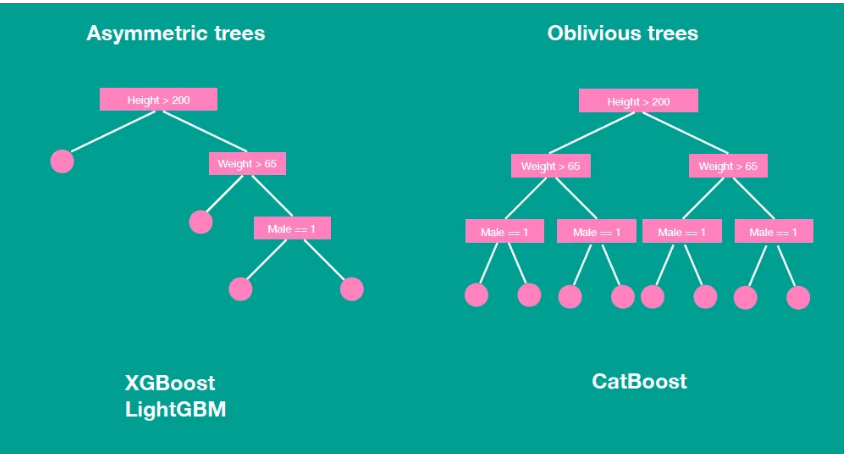

Source: Towards Data Science

### Explaining the model

Boosting is an ensemble method that combines multiple weak learners to create a strong learner. The boosting technique is iterative, sequential, and adaptive, this means that each model is built based on the errors of the previous models. 

CatBoost is a boosting algorithm that is designed to handle categorical features. CatBoost is able to generate symmetric trees, in every step leaves from the previous tree are split using the same condition. Also, it uses ordered boosting. However, the best characteristic of CatBoost (in our opinion) is that it can handle numerical and categorical features without encoding them. This is a great advantage for a data scientist, as it saves time and effort.

At first, we didn't believe that CatBoost encoding was better than manual one-hot encoding, but after testing it, we realized that it was true. Not only did it save us time, but it also improved our score.

## Methodology

First, as we didn't know anything about CatBoost we had to read the documentation and some tutorials. We also had to read the Optuna documentation to understand how to use it. 

We tried to use the same dataset and features that we used in the previous models with a satisfactory result but it wasn't enough to improve our score. So we decided to use different datasets: the one we used in the previous models, that one but with one-hot encoding, another removing outliers and the same but with one-hot encoding. We didn't get good results, or at least as good as we were expecting.

To execute the models, we decided to implement two models, one per target variable. Although we didn't really high results when we tried this technique with Random Forest, we still think it is a good approach. We also used Optuna to search the hyperparameters for each one.

### Optuna

Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. Some benefits of using Optuna are:
* Efficient search space exploration: It does not search over a grid space or randomly, it uses a technique called Tree-structured Parzen Estimator (TPE) to explore the search space efficiently.
* Pruning strategies.

What we have noticed, is that RandomizedSearchCV collapsed the computer, but Optuna didn't. It is faster and more efficient.

First, we need to define an objective function that will be optimized by Optuna. This function takes a trial object as input value and returns a value representing the performance of the model. In our case, we used AUC as the metric to optimize.

After all prepations have been done, we can define an "study" which is the core object of Optuna and stores the optimization process. After that, we simply run `study.optimize` to start the optimization process.

## Implementation

In this notebook, we have decided to use the original dataset without null values, to take advantage of the encoding of CatBoost. As we have explained in `Preprocessing.ipynb`, the null values were filled with -1 and a category 'missing'.

Catboost is able to handle multiple target variables, but we decided to keep it simple and implement one model per target variable. Also, we have implemented cross-validation to avoid overfitting and improve the model as our objective now is to improve the score as much as possible.

Summary of the steps:
1. Load and prepare the data.
2. Define the objective function.
3. Define the study.
4. Run the optimization process.
5. Train the model with the best hyperparameters.
6. Make predictions and submit the results.

In [ ]:
# import libraries
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy as np
import json

from sklearn.model_selection import train_test_split
from mlflow.create_dataset import Dataset
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
# load data
data = Dataset()
X, y, output = data.original_dataset()

# convert categorical columns to category type for CatBoost
categorical_columns = list(X.select_dtypes(include=['object']).columns)

X[categorical_columns] = X[categorical_columns].astype('category')
output[categorical_columns] = output[categorical_columns].astype('category')

In [3]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# split the target variables
h1_train = y_train["h1n1_vaccine"]
seasonal_train = y_train["seasonal_vaccine"]
h1_test = y_test["h1n1_vaccine"]    
seasonal_test = y_test["seasonal_vaccine"]

Now, let's explain CatBoost variables. 

- It will use 'AUC' as the metric to optimize 
- Define the categorical features by their name, as the input dataset is a pandas DataFrame.
- Early stopping is used to avoid overfitting and improve the speed of the study.
- Train directory parameter is used by CatBoost to store the models and other files generated during the training process.

In [ ]:
model = CatBoostClassifier(
        eval_metric='AUC',        
        cat_features=categorical_columns,
        train_dir='catboost_whole',  
        early_stopping_rounds=5, verbose=0,         
)

Optuna needs a function to optimize, so we created a function that receives the type of target variable and returns the best roc auc score.

Notice that we have implemented cross-validation with StratifiedKFold, as one of our target variables is imbalanced.

In [4]:
def objective_vaccine(trial, target):
    '''Objective function for Optuna study to optimize CatBoost hyperparameters for vaccine prediction.
    '''
    param_dist_random = {
        'iterations': trial.suggest_int('iterations', 100, 3000),
        'depth': trial.suggest_int('depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
    }

   
    if target == 'h1n1_vaccine': #change target
        target_data = h1_train
    elif target == 'seasonal_vaccine':
        target_data = seasonal_train
    else:
        raise ValueError(f"Unknown target column: {target}")

    model = CatBoostClassifier(
        eval_metric='AUC',        
        cat_features=categorical_columns,
        train_dir='catboost_whole',  
        early_stopping_rounds=5, verbose=0, **param_dist_random         
    )
    # Stratified KFold to avoid imbalance data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores = []
    #drop index as it gived an error
    X_train.reset_index(drop=True, inplace=True)
    target_data.reset_index(drop=True, inplace=True)

    for train_index, val_index in cv.split(X_train, target_data):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = target_data.iloc[train_index], target_data.iloc[val_index]

        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), use_best_model=True)
        #reuse already calculated auc to improve speed	
        auc = model.get_best_score()['validation']['AUC']
        auc_scores.append(auc)

    # get the mean of all splits
    mean_auc = np.mean(auc_scores)

    return float(mean_auc)

❗We want to highlight this line of code:
```python
auc = model.get_best_score()['validation']['AUC']
```
At this line, we are reusing the score calculated by CatBoost during fit, instead of manually calculating it which is more time-consuming. This simple line made a study last from 6 hours to 1 hour. We learned it the hard way.

In [27]:
################ Start Optuna Seasonal vaccine ################
study_s = optuna.create_study(directions=["maximize"]) # maximize the AUC
study_s.optimize(lambda trial: objective_vaccine(trial, target='seasonal_vaccine'), n_trials=100, show_progress_bar=True)

print("Seasonal done")
print(study_s.best_params)
print(study_s.best_value)

results = {
    "best_params": study_s.best_params,
    "best_value": study_s.best_value
}

# with open("seasonal_vaccine_results.json", "w") as f: # save the results in case of failure
#     json.dump(results, f, indent=4)

[I 2024-12-27 01:20:34,284] A new study created in memory with name: no-name-76006883-980c-4230-afb5-d0d44f9dc1ed
Best trial: 0. Best value: 0.82975:   1%|          | 1/100 [01:20<2:12:17, 80.18s/it]

[I 2024-12-27 01:21:54,463] Trial 0 finished with value: 0.8297504166771879 and parameters: {'iterations': 1566, 'depth': 13, 'learning_rate': 0.007203252845825082, 'l2_leaf_reg': 0.97374053799198, 'random_strength': 2.276774329043074, 'bagging_temperature': 0.49561022412452427, 'border_count': 122, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.8297504166771879.


Best trial: 1. Best value: 0.860471:   2%|▏         | 2/100 [03:58<3:26:13, 126.26s/it]

[I 2024-12-27 01:24:32,980] Trial 1 finished with value: 0.8604709736813516 and parameters: {'iterations': 2736, 'depth': 5, 'learning_rate': 0.13311493673749508, 'l2_leaf_reg': 0.004561133443048473, 'random_strength': 5.503944943921392, 'bagging_temperature': 0.5975202836095911, 'border_count': 174, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:   3%|▎         | 3/100 [05:40<3:06:08, 115.14s/it]

[I 2024-12-27 01:26:14,902] Trial 2 finished with value: 0.8567100934104779 and parameters: {'iterations': 1681, 'depth': 12, 'learning_rate': 0.1105307665995389, 'l2_leaf_reg': 1.1781309352940417, 'random_strength': 4.246915594605429, 'bagging_temperature': 0.2737332150997601, 'border_count': 177, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:   4%|▍         | 4/100 [06:08<2:09:15, 80.78s/it] 

[I 2024-12-27 01:26:43,000] Trial 3 finished with value: 0.8340083553698758 and parameters: {'iterations': 1501, 'depth': 12, 'learning_rate': 0.0014360316251550793, 'l2_leaf_reg': 0.13612491801999368, 'random_strength': 6.2475022612622695, 'bagging_temperature': 0.8362713395438237, 'border_count': 109, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:   5%|▌         | 5/100 [09:49<3:28:00, 131.37s/it]

[I 2024-12-27 01:30:24,066] Trial 4 finished with value: 0.8449884801672102 and parameters: {'iterations': 925, 'depth': 16, 'learning_rate': 0.007551588645418011, 'l2_leaf_reg': 0.0017173792669629509, 'random_strength': 9.960045078271492, 'bagging_temperature': 0.9873880027792664, 'border_count': 206, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:   6%|▌         | 6/100 [11:17<3:02:27, 116.46s/it]

[I 2024-12-27 01:31:51,586] Trial 5 finished with value: 0.8522666704731799 and parameters: {'iterations': 162, 'depth': 8, 'learning_rate': 0.021576692109142655, 'l2_leaf_reg': 0.0011370327228065232, 'random_strength': 2.909871420850431, 'bagging_temperature': 0.5075371591888949, 'border_count': 137, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:   7%|▋         | 7/100 [13:57<3:22:54, 130.90s/it]

[I 2024-12-27 01:34:32,228] Trial 6 finished with value: 0.8593598867012547 and parameters: {'iterations': 2912, 'depth': 15, 'learning_rate': 0.19851828628737728, 'l2_leaf_reg': 1.079362435184487, 'random_strength': 0.9286506051767836, 'bagging_temperature': 0.014571040299538374, 'border_count': 164, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:   8%|▊         | 8/100 [15:22<2:58:11, 116.21s/it]

[I 2024-12-27 01:35:56,981] Trial 7 finished with value: 0.8288269806824259 and parameters: {'iterations': 1892, 'depth': 15, 'learning_rate': 0.001600378158546703, 'l2_leaf_reg': 6.630009432712363, 'random_strength': 2.5613943390454206, 'bagging_temperature': 0.5379860905375059, 'border_count': 66, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:   9%|▉         | 9/100 [17:42<3:07:39, 123.74s/it]

[I 2024-12-27 01:38:17,263] Trial 8 finished with value: 0.8571167260232221 and parameters: {'iterations': 1223, 'depth': 8, 'learning_rate': 0.03986128489626729, 'l2_leaf_reg': 0.8392554067809181, 'random_strength': 9.824019905437456, 'bagging_temperature': 0.8258105153228511, 'border_count': 108, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:  10%|█         | 10/100 [17:56<2:14:30, 89.68s/it]

[I 2024-12-27 01:38:30,669] Trial 9 finished with value: 0.8286340122991638 and parameters: {'iterations': 1998, 'depth': 4, 'learning_rate': 0.009819329021411277, 'l2_leaf_reg': 0.0018656202404904415, 'random_strength': 8.188027554860446, 'bagging_temperature': 0.3011429547329788, 'border_count': 241, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:  11%|█         | 11/100 [21:24<3:06:55, 126.01s/it]

[I 2024-12-27 01:41:59,079] Trial 10 finished with value: 0.858919248479608 and parameters: {'iterations': 2954, 'depth': 4, 'learning_rate': 0.05621400420222633, 'l2_leaf_reg': 0.015350196858451678, 'random_strength': 6.1376689762168, 'bagging_temperature': 0.69841437664886, 'border_count': 36, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:  12%|█▏        | 12/100 [22:49<2:46:31, 113.53s/it]

[I 2024-12-27 01:43:24,071] Trial 11 finished with value: 0.8596746271227099 and parameters: {'iterations': 2960, 'depth': 7, 'learning_rate': 0.17561200224632645, 'l2_leaf_reg': 0.029487333582198037, 'random_strength': 0.027018368730977294, 'bagging_temperature': 0.03692058293536611, 'border_count': 175, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 1. Best value: 0.860471:  13%|█▎        | 13/100 [25:43<3:10:55, 131.67s/it]

[I 2024-12-27 01:46:17,481] Trial 12 finished with value: 0.8582738277410934 and parameters: {'iterations': 2462, 'depth': 7, 'learning_rate': 0.17759131155878716, 'l2_leaf_reg': 0.015382082064034628, 'random_strength': 4.7626601416329875, 'bagging_temperature': 0.02149134805692833, 'border_count': 202, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8604709736813516.


Best trial: 13. Best value: 0.86118:  14%|█▍        | 14/100 [28:59<3:36:29, 151.05s/it]

[I 2024-12-27 01:49:33,293] Trial 13 finished with value: 0.861180329273509 and parameters: {'iterations': 2428, 'depth': 6, 'learning_rate': 0.07295133110325916, 'l2_leaf_reg': 0.013006906520681143, 'random_strength': 0.4984063680304285, 'bagging_temperature': 0.25004669856729106, 'border_count': 249, 'grow_policy': 'Lossguide'}. Best is trial 13 with value: 0.861180329273509.


Best trial: 13. Best value: 0.86118:  15%|█▌        | 15/100 [32:31<4:00:21, 169.66s/it]

[I 2024-12-27 01:53:06,100] Trial 14 finished with value: 0.8554025091900967 and parameters: {'iterations': 2437, 'depth': 5, 'learning_rate': 0.06733334719426812, 'l2_leaf_reg': 0.004971183512043515, 'random_strength': 6.945646581840432, 'bagging_temperature': 0.2745644109787911, 'border_count': 247, 'grow_policy': 'Lossguide'}. Best is trial 13 with value: 0.861180329273509.


Best trial: 13. Best value: 0.86118:  16%|█▌        | 16/100 [36:41<4:31:17, 193.78s/it]

[I 2024-12-27 01:57:15,884] Trial 15 finished with value: 0.836744912669133 and parameters: {'iterations': 2359, 'depth': 10, 'learning_rate': 0.019203773328739966, 'l2_leaf_reg': 0.06996358046066604, 'random_strength': 3.7615272329356926, 'bagging_temperature': 0.37882237693759513, 'border_count': 204, 'grow_policy': 'Lossguide'}. Best is trial 13 with value: 0.861180329273509.


Best trial: 13. Best value: 0.86118:  17%|█▋        | 17/100 [38:39<3:56:24, 170.90s/it]

[I 2024-12-27 01:59:13,563] Trial 16 finished with value: 0.8589799104099448 and parameters: {'iterations': 2555, 'depth': 6, 'learning_rate': 0.03506787768655225, 'l2_leaf_reg': 0.005828547335448459, 'random_strength': 1.392541761951911, 'bagging_temperature': 0.15961469791778027, 'border_count': 224, 'grow_policy': 'SymmetricTree'}. Best is trial 13 with value: 0.861180329273509.


Best trial: 13. Best value: 0.86118:  18%|█▊        | 18/100 [46:10<5:48:39, 255.11s/it]

[I 2024-12-27 02:06:44,723] Trial 17 finished with value: 0.8608831891612324 and parameters: {'iterations': 2129, 'depth': 9, 'learning_rate': 0.08471149740048821, 'l2_leaf_reg': 0.005086405317717408, 'random_strength': 5.532244338357617, 'bagging_temperature': 0.6799176365464141, 'border_count': 153, 'grow_policy': 'Lossguide'}. Best is trial 13 with value: 0.861180329273509.


In [4]:
################ Start Optuna h1n1 vaccine ################
study_h1 = optuna.create_study(directions=["maximize"])
study_h1.optimize(lambda trial: objective_vaccine(trial, target='h1n1_vaccine'), n_trials=100, show_progress_bar=True)  

print("H1N1 done")
print(study_h1.best_params)
print(study_h1.best_value)

results = {
    "best_params": study_h1.best_params,
    "best_value": study_h1.best_value
}

# with open("h1_vaccine_results.json", "w") as f: # save the results in case of failure
#     json.dump(results, f, indent=4)

H1N1 done
{'bagging_temperature': 0.30983176219520503, 'border_count': 134, 'depth': 6, 'grow_policy': 'Lossguide', 'iterations': 2779, 'l2_leaf_reg': 7.50192142172408, 'learning_rate': 0.006885816530257467, 'loss_function': 'Logloss', 'random_strength': 1.414598986662248}
0.8707217427565673


Now that we have found the best hyperparameters, we can train a model and make predictions.

In [ ]:
# fit models with best parameters
model0 = CatBoostClassifier(
        eval_metric='AUC',        
        cat_features=categorical_columns,
        train_dir='catboost_whole',  
        early_stopping_rounds=5, verbose=0, **study_h1.best_params         
    )
model1 = CatBoostClassifier(
        eval_metric='AUC',        
        cat_features=categorical_columns,
        train_dir='catboost_whole',  
        early_stopping_rounds=5, verbose=0, **study_s.best_params         
    )

model0.fit(X_train, h1_train, verbose=1000)
model1.fit(X_train, seasonal_train, verbose=1000)

0:	learn: 0.6878328	total: 140ms	remaining: 6m 29s
100:	learn: 0.4447284	total: 2.38s	remaining: 1m 2s
200:	learn: 0.3842777	total: 4.46s	remaining: 57.3s
300:	learn: 0.3627001	total: 6.64s	remaining: 54.6s
400:	learn: 0.3518884	total: 8.66s	remaining: 51.3s
500:	learn: 0.3449091	total: 10.7s	remaining: 48.5s
600:	learn: 0.3398456	total: 12.7s	remaining: 45.8s
700:	learn: 0.3357366	total: 14.6s	remaining: 43.3s
800:	learn: 0.3323286	total: 16.5s	remaining: 40.8s
900:	learn: 0.3293522	total: 18.5s	remaining: 38.6s
1000:	learn: 0.3269275	total: 20.4s	remaining: 36.3s
1100:	learn: 0.3246178	total: 22.4s	remaining: 34.1s
1200:	learn: 0.3222707	total: 24.3s	remaining: 31.9s
1300:	learn: 0.3199167	total: 26.2s	remaining: 29.8s
1400:	learn: 0.3175158	total: 28.1s	remaining: 27.7s
1500:	learn: 0.3147005	total: 30.2s	remaining: 25.7s
1600:	learn: 0.3115932	total: 32.3s	remaining: 23.8s
1700:	learn: 0.3081273	total: 34.5s	remaining: 21.9s
1800:	learn: 0.3046960	total: 36.6s	remaining: 19.9s
1900

In [12]:
# extract predictions
y_pred0 = model0.predict(X_test)
y_pred1 = model1.predict(X_test)
y_pred_prob0 = model0.predict_proba(X_test)
y_pred_prob1 = model1.predict_proba(X_test)

# combine predictions of both models
y_pred = np.column_stack([y_pred0, y_pred1])

Generate metrics to test the performance of the model.

In [ ]:
################ METRICS ################
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

Accuracy: 0.6868214152002995
ROC AUC: 0.7546046843692666
F1: 0.6805882143166997


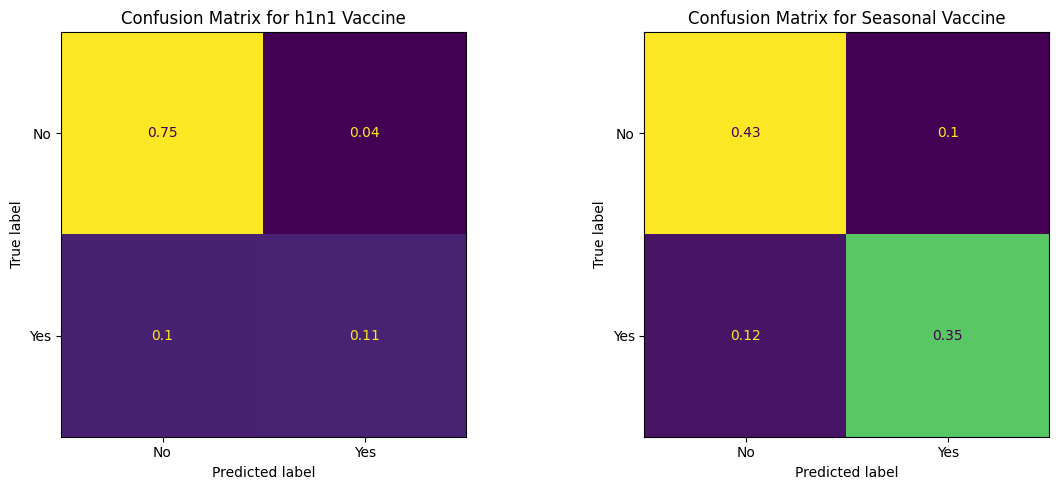

In [16]:
# confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# H1N1 vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred0, normalize='all')
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['No', 'Yes'])
disp_h1n1.plot(ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix for h1n1 Vaccine')

# Confusion matrix for seasonal vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred1, normalize='all')
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['No', 'Yes'])
disp_seasonal.plot(ax=ax[1], colorbar=False)
ax[1].set_title('Confusion Matrix for Seasonal Vaccine')

plt.tight_layout()
plt.show()

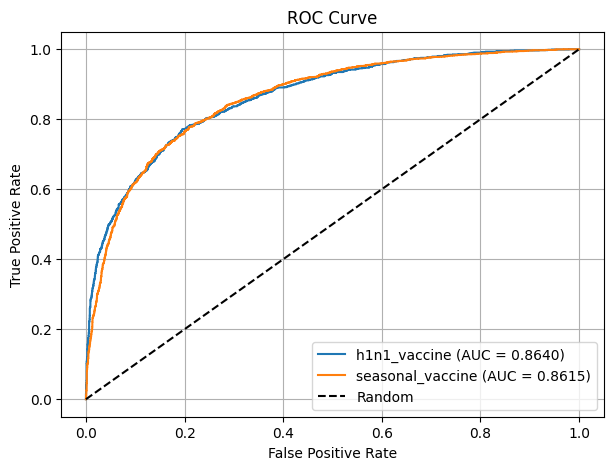

In [17]:
y_scores = [p[:, 1] for p in [y_pred_prob0, y_pred_prob1]]

plt.figure(figsize=(7, 5))
for i, y_score in enumerate(y_scores):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_score)
    auc = roc_auc_score(y_test.iloc[:, i], y_score)
    plt.plot(fpr, tpr, label=f'{y_test.columns[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Submission

In [ ]:
predictions0 = model0.predict_proba(output)
predictions1 = model1.predict_proba(output)

h1n1_probs = predictions0[:, 1]  
seasonal_probs = predictions1[:, 1] 

predict = pd.DataFrame({
    "respondent_id": output.index,
    "h1n1_vaccine": h1n1_probs,
    "seasonal_vaccine": seasonal_probs
})
predict.set_index("respondent_id", inplace=True)

Uncomment the following line to save the results.

In [ ]:
# predict.to_csv("predictions.csv")

## Results

Executing Catboost could be a little bit slow some times, specially if you don't understand the nuances of the library. Some runs took half a day while others took just a few hours. We have tried to optimize the code as much as possible, but we still have some doubts about the best way to implement it.

In general, we got a better score than the previous models in the local dataset but not all of our tests improved the score on the competition page. We believe that the problem is in the dataset, as we have tried different datasets and the results were not as good as we expected. 

The tests with the tag 'selected' are the ones tested on the competion page. Some runs don't have a roc auc score because we forgot to save it, but anyways it's just the mean of the two other values.

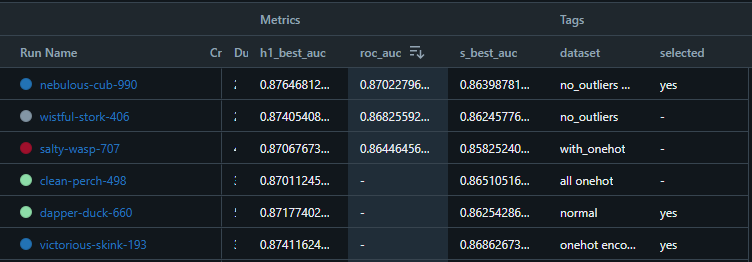

Results of the models with the tag selected:

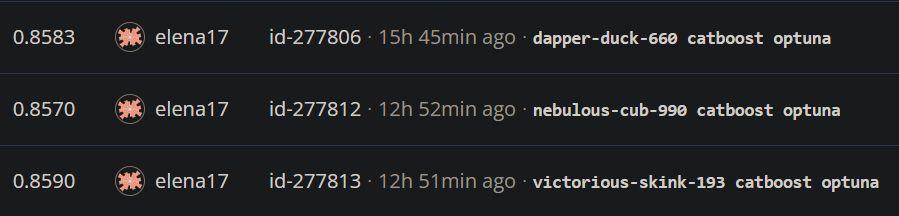

All of the models have lower scores on the competition page than the ones we got in the local tests. This might mean that the model is a bit overfitted or that the competition dataset has some differences from the one we used to train and our model wasn't able to generalize well.

Now we will explain a bit more about each run:
* dapper-duck-660: This was the first run we did. The dataset used was the one we used in the previous models. We got a good score, but we thought we could get a better one.
* nebulous-cub-990: This was the second run we did. The dataset used was one without outliers and with one-hot encoding. Surprisingly, we got a lower score than the previous run although it performed better in the local tests.
* victorious-skink-193: That day we had an extra opportunity into the competition, so we decided to try another dataset. In this case, it's the same dataset as dapper-duck-660 but with one-hot encoding. We got a better score than the previous runs.

We think the improvement isn't only based on the dataset but also on the train-test split and of course the hyperparameter seach that is not deterministic. On a second thought, it might have been better to set a deterministic seed.